<a href="https://colab.research.google.com/github/patricio-tech/proyectos/blob/master/RL4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Monte Carlo Methods**

**Exploration-Explanation Dilemma**

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
env = gym.make('Blackjack-v0')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [2]:
state = env.reset()
while True:
       print('state:', state)
       action = env.action_space.sample()
       print('action: ', action) 
       state, reward, done, info = env.step(action)
       if done:
          if reward > 0: 
             print('Reward: ', reward)                 
          else: 
             print('Reward: ', reward)
          break

state: (19, 6, True)
action:  1
state: (18, 6, False)
action:  1
Reward:  -1.0


In [3]:
def generate_episode(env):
    episode = []
    state = env.reset()
    while True:
        probs = [0.75, 0.25] if state[0] > 18 else [0.25, 0.75]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [4]:
for i in range(10):
    print(generate_episode(env))

[((11, 4, False), 1, 0.0), ((14, 4, False), 1, 0.0), ((18, 4, False), 0, -1.0)]
[((15, 6, True), 1, 0.0), ((15, 6, False), 1, 0.0), ((17, 6, False), 0, 1.0)]
[((18, 6, False), 1, -1.0)]
[((12, 6, False), 0, -1.0)]
[((11, 7, False), 1, 0.0), ((21, 7, False), 0, 1.0)]
[((12, 6, False), 1, -1.0)]
[((9, 3, False), 1, 0.0), ((13, 3, False), 1, 0.0), ((21, 3, False), 0, 0.0)]
[((13, 3, False), 0, 1.0)]
[((20, 5, False), 1, -1.0)]
[((20, 10, True), 0, 1.0)]


In [5]:
episode = generate_episode(env)
print (episode)
states, actions, rewards = zip(*episode)
print('states:  ',states)
print('actions: ', actions)
print('rewards: ', rewards)

[((10, 1, False), 1, 0.0), ((21, 1, True), 1, 0.0), ((19, 1, False), 0, -1.0)]
states:   ((10, 1, False), (21, 1, True), (19, 1, False))
actions:  (1, 1, 0)
rewards:  (0.0, 0.0, -1.0)


In [6]:
def mc_prediction(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in range(1, num_episodes+1):
        
        if episode % 10000 == 0: # monitor progress
            print("\repisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
        
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)

        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [7]:
num_episodes=1000000

Q = mc_prediction(env, num_episodes, generate_episode)

episode 1000000/1000000.

In [8]:
for i in range(5):
  print(Q.popitem())

((12, 8, True), array([-0.5       , -0.11182109]))
((12, 2, True), array([-0.40740741, -0.10315186]))
((12, 7, True), array([-0.57522124, -0.12202381]))
((4, 2, False), array([-0.4       , -0.30654762]))
((16, 6, True), array([-0.1       , -0.19497608]))


In [9]:
State_Value_table={}
for state, actions in Q.items():
     State_Value_table[state]= (state[0]>18)*(np.dot([0.75, 0.25],actions)) + (state[0]<=18)*(np.dot([0.75, 0.25],actions))

In [10]:
# source: https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

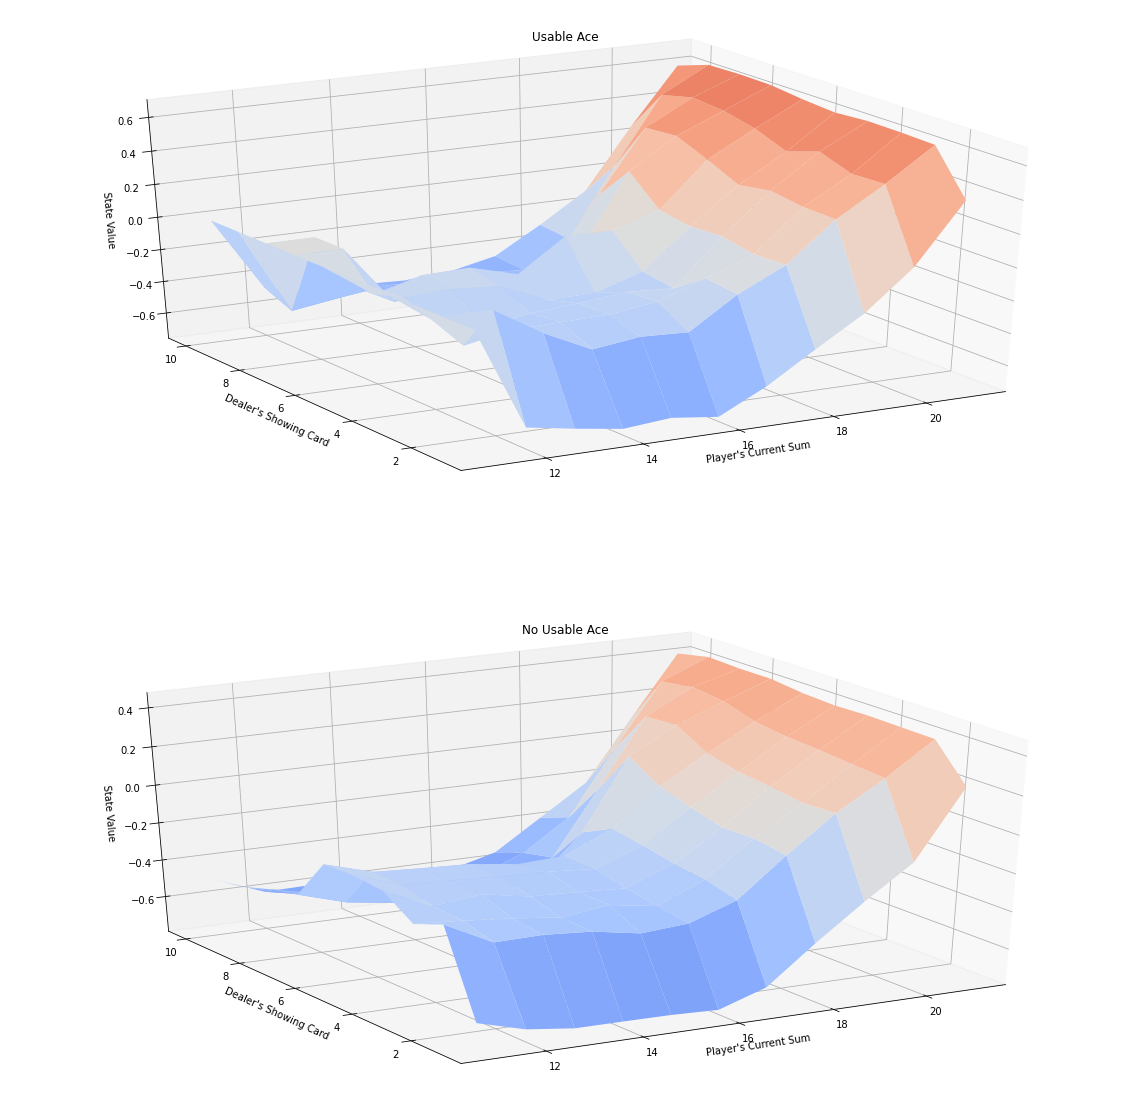

In [11]:
plot_blackjack_values(State_Value_table)